# Broadband Growth Across the US
## Machine Learning
### Chester Hitz | Springboard Data Science Career Track | Capstone I

The goal of this final component of my capstone is to apply what I have discovered thus far in my project and apply it to building a predictive model. 

### Work thus far
I started this project with my data wrangling component, where I assembled a DataFrame consisting of 13k rows, each one representing a county in a particular year across a four year period (2011-2015) with a target variable. The target variable is a number corresponding to a category for "residential fixed Internet access connections per 1,000 households by county for both service over 200 kbps in at least one direction and service at least 10 Mbps down / 1 Mbps up.". This is the BSC, or broadband subscription category. The categories are listed as follows, with x representing connections per 1,000 households:
* 0: Zero 
* 1: Zero < x <= 200 
* 2: 200 < x <= 400 
* 3: 400 < x <= 600 
* 4: 600 < x <= 800 
* 5: 800 < x

I then populated this DataFrame further with various features pulled from the census API and other sources to complete my DataWrangling component. In my Data Storytelling and Inferential Statistics modules, I examined the data and found 1) that BSC did move upward over the study period and 2) that economic factors were the most closely correlated to BSC.

In this final module, I will build on those previous units to construct a predictive model. Though I am technically predicting for a category, the category is essentially bins for numerical data, so a scikit-learn LinearRegression model will be used in this case.

In [1]:
# begin by importing all relevant libraries & previous data
# standard libraries...
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# ... and various scikit-learn functions
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer

# import relevant data
broadband = pd.read_csv('broadband.csv', dtype={'county_fips':str,'Year':str})
broadband['Year'] = broadband.Year.astype(int)

My first step here is fitting my data to a standard Linear Regression model from sci-kit learn and calculating the RMSE of the predicted scores.

In [2]:
# remove unnecessary features, impute NaN values, and isolate the features from the target in a new DataFrame
lr_bb = broadband.drop(['Unnamed: 0', 'state', 'statename'], axis=1)
df_features = lr_bb.drop('BSC', axis = 1)
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
df_features = imp.fit_transform(df_features)

# split the data 80/20 between training and test data
X_train, X_test, y_train, y_test = train_test_split(df_features, lr_bb.BSC, test_size = .2, random_state=42)

# fit a linear regression model to the training data
lm = LinearRegression().fit(X_train,y_train)
    
#predict on the test data
BSC_predicted = lm.predict(X_test)

# since the maximum BSC is 5, this places a ceiling on values.
BSC_predicted[BSC_predicted > 5] = 5
BSC_predicted = BSC_predicted

# calculate an RMSE from this model
rmse = np.sqrt(mean_squared_error(BSC_predicted, y_test))
rmse

0.56795851320624757

Fitting my data to the most generalized linear regression model produces an RMSE of .57, meaning that is the average error from actual BSC is about half. This is not awful, but improvements can be made.

One useful improvement was segmenting the data based on its real-world origins. Each record is a county in a particular year, and we are trying to predict based on various demographic factors collected by the census bureau. In order to improve RMSE here, I segmented the data into three distinct DataFrames representing rural, semirural, and urban counties and trained a regression model on each (based on definitions from the census bureau). I did this because the various features operate differently at different levels of rurality, for example I discovered that income matters much less as rurality increases. The result is better trained models that produce lower RMSE scores overall.

In [5]:
# build a function to train and test different DataFrames

imp = Imputer(missing_values='NaN', strategy='median', axis=0)

def LR_Pipeline(df):
    # clean & segment data
    df_features = df.drop('BSC',axis = 1)
    df_features = imp.fit_transform(df_features)
    X_train, X_test, y_train, y_test = train_test_split(df_features, df.BSC, test_size = .2, random_state=42)
    
    # fir data to a linear regression model
    lm = LinearRegression().fit(X_train,y_train)
    
    # use it to predict
    BSC_predicted = lm.predict(X_test)
    BSC_predicted[BSC_predicted > 5] = 5
    
    # evaluate
    rmse = np.sqrt(mean_squared_error(BSC_predicted, y_test))
    df.loc[:,'Predicted'] = lm.predict(df_features)
    df.loc[:,'Residual'] = df['BSC'] - df['Predicted']

    print('Model built. RMSE on data:', rmse)

In [10]:
# segment the DataFrames and train individual linear regression models on each
urban_bb = lr_bb[lr_bb['Rural_Pct'] < 50]
semirural_bb = lr_bb[(lr_bb['Rural_Pct'] > 50) & (broadband['Rural_Pct'] < 99.9)]
rural_bb = lr_bb[lr_bb['Rural_Pct'] == 100]

print('urban')
LR_Pipeline(urban_bb)
print('semirural')
LR_Pipeline(semirural_bb)
print('rural')
LR_Pipeline(rural_bb)

urban


/Users/ChesterHitz/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ChesterHitz/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Model built. RMSE on data: 0.461167757879
semirural
Model built. RMSE on data: 0.550383478576
rural
Model built. RMSE on data: 0.710292217035


In order to improve and understand my model, I create a function below that produces a table showing all the different t-scores and p-values for each variable in each model.

In [7]:
#def feature_eval(df)
ols_str = 'BSC ~ '
features = list(lr_bb.columns)
features.remove('county_fips')
features.remove('BSC')
for feature in features: 
    ols_str = ols_str + " + " + str(feature)
print(ols_str)

t_df=pd.DataFrame()

def LR_evaluator(df, name):
    m = ols(ols_str, df).fit()
    t_df[name +' T'] = m.tvalues
    t_df[name +' |t|>P'] = np.round(m.pvalues, 4)

LR_evaluator(lr_bb, 'all')
LR_evaluator(urban_bb, 'urban')
LR_evaluator(semirural_bb, 'semirural')
LR_evaluator(rural_bb, 'rural')
t_df

BSC ~  + Year + colleges + Rural_Pct + Population + Income + HomePrice + Families + PctBachelors + EmploymentRate + InformationJobs + AgJobs + PublicTrans + BornInState + HighSchoolGrads + MobileHomes + AptBuildings + NoEnglish + InformationJobsPer + ArmedForcesPer + Unemployed + TotalHouseholds + SameHouseResidence + TractArea + PopDensity


,all T,all |t|>P,urban T,urban |t|>P,semirural T,semirural |t|>P,rural T,rural |t|>P
Intercept,-34.070996,0.0000,-27.624205,0.0000,-17.742947,0.0000,-13.718721,0.0000
Year,34.261561,0.0000,27.733427,0.0000,17.737279,0.0000,13.821279,0.0000
colleges,-4.388679,0.0000,-4.265611,0.0000,1.394993,0.1631,-0.296012,0.7672
Rural_Pct,-19.529917,0.0000,-11.622910,0.0000,1.203514,0.2288,-13.718721,0.0000
Population,-2.032311,0.0421,0.280795,0.7789,1.717724,0.0859,-0.050376,0.9598
Income,10.111458,0.0000,12.914564,0.0000,1.250595,0.2111,2.165235,0.0304
HomePrice,10.411203,0.0000,11.123864,0.0000,8.951883,0.0000,-3.231163,0.0012
Families,1.773436,0.0762,0.817527,0.4137,-3.561106,0.0004,0.897980,0.3693
PctBachelors,14.147823,0.0000,6.331539,0.0000,3.408093,0.0007,9.780344,0.0000
EmploymentRate,-8.246118,0.0000,-6.228090,0.0000,-2.434300,0.0150,-0.502844,0.6151


There is a lot to unpack here. Overall, I can predict urban and semirural counties fairly well and better than when the model is trained on the entire dataset. Urban counties in particular have an RMSE of .45, meaning that the average prediction is only off by .45. Considering that urban counties are the most numerous, this is good news.

However, the more rural the county is, generally the worse off the model gets at predicting BSC. This is seen in the higher Root Mean Squared Error as well as the overall lower isolated t-scores. Features that play a large role in urban and semirural counties are much less useful in prediction. For example, median income is not strongly predictive in rural counties (t: 1.68, p: .09). This means that people subscribe to internet at equal rates no matter if the population is rich or poor in rural areas.

In LinearRegression, it is always best to take the simplest approach possible and use the least number of predictor variables when possible. Below I define a function that removes any feature that produces an p-value of .05 or higher (adjustable), and then recreates the reduced model and yields its RMSE. I apply this to the three subsets of my DataFrame I defined earlier.

In [9]:
def model_simplifier(df, p_value):
    m = ols(ols_str, df).fit()
    good_features = list((m.pvalues[m.pvalues < p_value]).index)
    good_features.insert(-1,'BSC')
    good_features.remove('Intercept')
    return(df[good_features])

LR_Pipeline(model_simplifier(lr_bb,.05))
LR_Pipeline(model_simplifier(urban_bb,.05))
LR_Pipeline(model_simplifier(semirural_bb,.05))
LR_Pipeline(model_simplifier(rural_bb,.05))

/Users/ChesterHitz/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ChesterHitz/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Model built. RMSE on data: 0.567807287337
Model built. RMSE on data: 0.460748012101
Model built. RMSE on data: 0.553019869461
Model built. RMSE on data: 0.708065078537


This is an effective means of removing unnecessary features from each model.

## Applications

Reflecting again on the real-world origins and goals of this project, it is very useful to examine the residuals of the prediction since they show which counties would be best for further expansion by telecom companies. A histogram of the residuals (actual - predicted) is below.

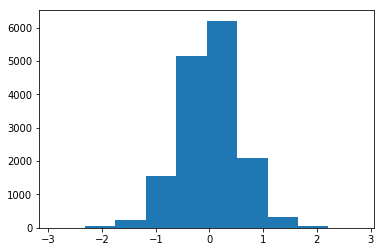

In [8]:
# reconstruct the dataframe
resid_df = pd.concat([urban_bb, semirural_bb, rural_bb])
plt.hist(resid_df['Residual'])
plt.show()

In [ ]:
under_df = resid_df[resid_df['Residual'] < 0]
under_df.describe()

under_df[['county_fips', 'Residual']].to_csv('residual_map.csv')
#need to isolate year

◊ simplify models
◊ plot residuals
◊ map variances
◊ explain utility of models